In [29]:
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn.functional as F

from PIL import Image
from tqdm import tqdm
from pathlib import Path
from models import VGG16
from torch import nn
from torchvision import transforms
from torch.utils.data import DataLoader
from torchsummary import summary

print(f"torch version {torch.__version__}")
print(f"torchvision version {torchvision.__version__}")

torch version 2.0.0+cu117
torchvision version 0.15.1+cu117


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
ROOT = Path("/home/famousdeer/Desktop/Praca magisterska/Program/data")
BATCH_SIZE = 128
EPOCH = 10

In [10]:
transform_train = transforms.Compose([
                                        transforms.RandomCrop(size=32,
                                                              padding=4),
                                        transforms.RandomHorizontalFlip(),
                                        transforms.ToTensor()
                                        ])

transform_test = transforms.Compose([
                                        transforms.ToTensor()
                                        ])

In [11]:
train_dataset = torchvision.datasets.CIFAR10(root=ROOT,
                                             train=True,
                                             download=True,
                                             transform=transform_train
                                             )
test_dataset = torchvision.datasets.CIFAR10(root=ROOT,
                                            train=False,
                                            download=True,
                                            transform=transform_test)

Files already downloaded and verified
Files already downloaded and verified


In [12]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=4)
test_loader = DataLoader(dataset=test_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=False,
                         num_workers=4)

In [14]:
classes = test_dataset.classes
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [8]:
model = VGG16(input_shape=3, output_shape=len(classes)).to(device)
summary(model, (3, 32, 32))


Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 64, 16, 16]          --
|    └─Conv2d: 2-1                       [-1, 64, 32, 32]          1,792
|    └─BatchNorm2d: 2-2                  [-1, 64, 32, 32]          128
|    └─ReLU: 2-3                         [-1, 64, 32, 32]          --
|    └─Conv2d: 2-4                       [-1, 64, 32, 32]          36,928
|    └─ReLU: 2-5                         [-1, 64, 32, 32]          --
|    └─MaxPool2d: 2-6                    [-1, 64, 16, 16]          --
├─Sequential: 1-2                        [-1, 128, 8, 8]           --
|    └─Conv2d: 2-7                       [-1, 128, 16, 16]         73,856
|    └─BatchNorm2d: 2-8                  [-1, 128, 16, 16]         256
|    └─ReLU: 2-9                         [-1, 128, 16, 16]         --
|    └─Conv2d: 2-10                      [-1, 128, 16, 16]         147,584
|    └─BatchNorm2d: 2-11                 [-1, 128, 16, 16]         

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 64, 16, 16]          --
|    └─Conv2d: 2-1                       [-1, 64, 32, 32]          1,792
|    └─BatchNorm2d: 2-2                  [-1, 64, 32, 32]          128
|    └─ReLU: 2-3                         [-1, 64, 32, 32]          --
|    └─Conv2d: 2-4                       [-1, 64, 32, 32]          36,928
|    └─ReLU: 2-5                         [-1, 64, 32, 32]          --
|    └─MaxPool2d: 2-6                    [-1, 64, 16, 16]          --
├─Sequential: 1-2                        [-1, 128, 8, 8]           --
|    └─Conv2d: 2-7                       [-1, 128, 16, 16]         73,856
|    └─BatchNorm2d: 2-8                  [-1, 128, 16, 16]         256
|    └─ReLU: 2-9                         [-1, 128, 16, 16]         --
|    └─Conv2d: 2-10                      [-1, 128, 16, 16]         147,584
|    └─BatchNorm2d: 2-11                 [-1, 128, 16, 16]         

In [9]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-4)

In [10]:
# Training
def train(epoch):
    print('\nTRAINING\nEpoch: %d' % epoch)
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        if batch_idx % 50 == 0:
            print(f"{batch_idx}: Loss: {(train_loss/(batch_idx+1)):.3f} | Acc: {(100.0*correct/total):.3f} | Correct/Total: {correct}/{total}")

In [11]:
# Testing
def test(epoch):
    print("TESTING")
    global best_acc
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(test_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = loss_fn(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            if batch_idx % 50 == 0:
                print(f"{batch_idx}: Loss: {(test_loss/(batch_idx+1)):.3f} | Acc: {(100.0*correct/total):.3f} | Correct/Total: {correct}/{total}")

In [16]:
for epoch in tqdm(range(EPOCH)):
    train(epoch)
    test(epoch)

  0%|          | 0/10 [00:00<?, ?it/s]


TRAINING
Epoch: 0
0: Loss: 0.295 | Acc: 91.406 | Correct/Total: 117/128
50: Loss: 0.404 | Acc: 86.688 | Correct/Total: 5659/6528
100: Loss: 0.401 | Acc: 86.649 | Correct/Total: 11202/12928
150: Loss: 0.401 | Acc: 86.651 | Correct/Total: 16748/19328
200: Loss: 0.405 | Acc: 86.447 | Correct/Total: 22241/25728
250: Loss: 0.408 | Acc: 86.317 | Correct/Total: 27732/32128
300: Loss: 0.411 | Acc: 86.150 | Correct/Total: 33192/38528
350: Loss: 0.411 | Acc: 86.245 | Correct/Total: 38748/44928
TESTING
0: Loss: 0.449 | Acc: 85.938 | Correct/Total: 110/128
50: Loss: 0.467 | Acc: 84.436 | Correct/Total: 5512/6528


 10%|█         | 1/10 [01:20<12:00, 80.05s/it]


TRAINING
Epoch: 1
0: Loss: 0.278 | Acc: 91.406 | Correct/Total: 117/128
50: Loss: 0.378 | Acc: 87.439 | Correct/Total: 5708/6528
100: Loss: 0.383 | Acc: 87.260 | Correct/Total: 11281/12928
150: Loss: 0.379 | Acc: 87.412 | Correct/Total: 16895/19328
200: Loss: 0.380 | Acc: 87.426 | Correct/Total: 22493/25728
250: Loss: 0.382 | Acc: 87.288 | Correct/Total: 28044/32128
300: Loss: 0.382 | Acc: 87.274 | Correct/Total: 33625/38528
350: Loss: 0.384 | Acc: 87.208 | Correct/Total: 39181/44928
TESTING
0: Loss: 0.362 | Acc: 89.062 | Correct/Total: 114/128
50: Loss: 0.450 | Acc: 84.819 | Correct/Total: 5537/6528


 20%|██        | 2/10 [02:40<10:43, 80.43s/it]


TRAINING
Epoch: 2
0: Loss: 0.312 | Acc: 86.719 | Correct/Total: 111/128
50: Loss: 0.364 | Acc: 88.373 | Correct/Total: 5769/6528
100: Loss: 0.369 | Acc: 88.088 | Correct/Total: 11388/12928
150: Loss: 0.363 | Acc: 88.069 | Correct/Total: 17022/19328
200: Loss: 0.371 | Acc: 87.640 | Correct/Total: 22548/25728
250: Loss: 0.370 | Acc: 87.649 | Correct/Total: 28160/32128
300: Loss: 0.372 | Acc: 87.516 | Correct/Total: 33718/38528
350: Loss: 0.372 | Acc: 87.522 | Correct/Total: 39322/44928
TESTING
0: Loss: 0.370 | Acc: 91.406 | Correct/Total: 117/128
50: Loss: 0.439 | Acc: 85.892 | Correct/Total: 5607/6528


 30%|███       | 3/10 [04:00<09:22, 80.31s/it]


TRAINING
Epoch: 3
0: Loss: 0.320 | Acc: 85.938 | Correct/Total: 110/128
50: Loss: 0.339 | Acc: 88.097 | Correct/Total: 5751/6528
100: Loss: 0.340 | Acc: 88.188 | Correct/Total: 11401/12928
150: Loss: 0.341 | Acc: 88.317 | Correct/Total: 17070/19328
200: Loss: 0.342 | Acc: 88.417 | Correct/Total: 22748/25728
250: Loss: 0.344 | Acc: 88.284 | Correct/Total: 28364/32128
300: Loss: 0.347 | Acc: 88.222 | Correct/Total: 33990/38528
350: Loss: 0.345 | Acc: 88.330 | Correct/Total: 39685/44928
TESTING
0: Loss: 0.400 | Acc: 85.938 | Correct/Total: 110/128
50: Loss: 0.445 | Acc: 85.202 | Correct/Total: 5562/6528


 40%|████      | 4/10 [05:17<07:53, 79.00s/it]


TRAINING
Epoch: 4
0: Loss: 0.238 | Acc: 91.406 | Correct/Total: 117/128
50: Loss: 0.311 | Acc: 89.568 | Correct/Total: 5847/6528
100: Loss: 0.310 | Acc: 89.604 | Correct/Total: 11584/12928
150: Loss: 0.315 | Acc: 89.404 | Correct/Total: 17280/19328
200: Loss: 0.314 | Acc: 89.401 | Correct/Total: 23001/25728
250: Loss: 0.318 | Acc: 89.315 | Correct/Total: 28695/32128
300: Loss: 0.319 | Acc: 89.182 | Correct/Total: 34360/38528
350: Loss: 0.321 | Acc: 89.172 | Correct/Total: 40063/44928
TESTING
0: Loss: 0.416 | Acc: 85.156 | Correct/Total: 109/128
50: Loss: 0.445 | Acc: 85.080 | Correct/Total: 5554/6528


 50%|█████     | 5/10 [06:37<06:35, 79.17s/it]


TRAINING
Epoch: 5
0: Loss: 0.367 | Acc: 86.719 | Correct/Total: 111/128
50: Loss: 0.292 | Acc: 90.211 | Correct/Total: 5889/6528
100: Loss: 0.300 | Acc: 90.006 | Correct/Total: 11636/12928
150: Loss: 0.298 | Acc: 90.087 | Correct/Total: 17412/19328
200: Loss: 0.299 | Acc: 89.945 | Correct/Total: 23141/25728
250: Loss: 0.303 | Acc: 89.785 | Correct/Total: 28846/32128
300: Loss: 0.304 | Acc: 89.719 | Correct/Total: 34567/38528
350: Loss: 0.303 | Acc: 89.746 | Correct/Total: 40321/44928
TESTING
0: Loss: 0.364 | Acc: 86.719 | Correct/Total: 111/128
50: Loss: 0.413 | Acc: 86.443 | Correct/Total: 5643/6528


 60%|██████    | 6/10 [07:56<05:17, 79.27s/it]


TRAINING
Epoch: 6
0: Loss: 0.292 | Acc: 90.625 | Correct/Total: 116/128
50: Loss: 0.266 | Acc: 91.192 | Correct/Total: 5953/6528
100: Loss: 0.281 | Acc: 90.811 | Correct/Total: 11740/12928
150: Loss: 0.281 | Acc: 90.630 | Correct/Total: 17517/19328
200: Loss: 0.287 | Acc: 90.407 | Correct/Total: 23260/25728
250: Loss: 0.289 | Acc: 90.364 | Correct/Total: 29032/32128
300: Loss: 0.288 | Acc: 90.386 | Correct/Total: 34824/38528
350: Loss: 0.287 | Acc: 90.400 | Correct/Total: 40615/44928
TESTING
0: Loss: 0.392 | Acc: 89.062 | Correct/Total: 114/128
50: Loss: 0.437 | Acc: 85.463 | Correct/Total: 5579/6528


 70%|███████   | 7/10 [09:16<03:57, 79.28s/it]


TRAINING
Epoch: 7
0: Loss: 0.200 | Acc: 94.531 | Correct/Total: 121/128
50: Loss: 0.264 | Acc: 91.452 | Correct/Total: 5970/6528
100: Loss: 0.268 | Acc: 91.174 | Correct/Total: 11787/12928
150: Loss: 0.272 | Acc: 91.034 | Correct/Total: 17595/19328
200: Loss: 0.272 | Acc: 90.913 | Correct/Total: 23390/25728
250: Loss: 0.275 | Acc: 90.837 | Correct/Total: 29184/32128
300: Loss: 0.274 | Acc: 90.872 | Correct/Total: 35011/38528
350: Loss: 0.277 | Acc: 90.734 | Correct/Total: 40765/44928
TESTING
0: Loss: 0.409 | Acc: 86.719 | Correct/Total: 111/128
50: Loss: 0.448 | Acc: 85.738 | Correct/Total: 5597/6528


 80%|████████  | 8/10 [10:35<02:38, 79.36s/it]


TRAINING
Epoch: 8
0: Loss: 0.202 | Acc: 93.750 | Correct/Total: 120/128
50: Loss: 0.249 | Acc: 91.207 | Correct/Total: 5954/6528
100: Loss: 0.248 | Acc: 91.368 | Correct/Total: 11812/12928
150: Loss: 0.249 | Acc: 91.417 | Correct/Total: 17669/19328
200: Loss: 0.252 | Acc: 91.433 | Correct/Total: 23524/25728
250: Loss: 0.257 | Acc: 91.304 | Correct/Total: 29334/32128
300: Loss: 0.258 | Acc: 91.279 | Correct/Total: 35168/38528
350: Loss: 0.259 | Acc: 91.259 | Correct/Total: 41001/44928
TESTING
0: Loss: 0.330 | Acc: 91.406 | Correct/Total: 117/128
50: Loss: 0.434 | Acc: 86.106 | Correct/Total: 5621/6528


 90%|█████████ | 9/10 [11:55<01:19, 79.44s/it]


TRAINING
Epoch: 9
0: Loss: 0.233 | Acc: 93.750 | Correct/Total: 120/128
50: Loss: 0.251 | Acc: 91.789 | Correct/Total: 5992/6528
100: Loss: 0.247 | Acc: 91.677 | Correct/Total: 11852/12928
150: Loss: 0.249 | Acc: 91.582 | Correct/Total: 17701/19328
200: Loss: 0.250 | Acc: 91.550 | Correct/Total: 23554/25728
250: Loss: 0.250 | Acc: 91.574 | Correct/Total: 29421/32128
300: Loss: 0.253 | Acc: 91.487 | Correct/Total: 35248/38528
350: Loss: 0.253 | Acc: 91.511 | Correct/Total: 41114/44928
TESTING
0: Loss: 0.334 | Acc: 92.188 | Correct/Total: 118/128
50: Loss: 0.422 | Acc: 86.734 | Correct/Total: 5662/6528


100%|██████████| 10/10 [13:15<00:00, 79.50s/it]


In [17]:
torch.save(model.state_dict(), ROOT / "cifar-10-batches-py" / "models" / "VGG16.pth")

In [22]:
def make_predictions(model: torch.nn.Module,
                     data,
                     device: torch.device = device):
    pred_probs = []
    model.to(device)
    model.eval()
    with torch.inference_mode():
        # Prepare the sample (add a batch dimension and pass to target device)
        data = torch.unsqueeze(data, dim=0).to(device)      
        # Forward pass (model outputs raw logits)
        pred_logits = model(data)     
        # Get prediction probability (logit -> prediction probability)
        pred_prob = torch.softmax(pred_logits.squeeze(), dim=0)     
        # Get pred_prob off the GPU for futher calculation
        pred_probs.append(pred_prob.cpu())

    # Stack the pred_probs to turn list into a tensor
    return torch.stack(pred_probs)

In [46]:
img = Image.open("/home/famousdeer/Desktop/Praca magisterska/Program/data/cifar-10-batches-py/test.jpg")
img.size

(1800, 1800)

In [47]:
img = img.resize((32,32))
img = transforms.ToTensor()(img)

In [48]:
model = VGG16(input_shape=3, output_shape=len(classes))
model.load_state_dict(torch.load(ROOT / "cifar-10-batches-py" / "models" / "VGG16.pth"))

<All keys matched successfully>

In [49]:
pred_probs = make_predictions(model=model,
                              data=img,
                              device=device)

In [50]:
pred_classes= pred_probs.argmax(dim=1)
pred_classes

tensor([3])

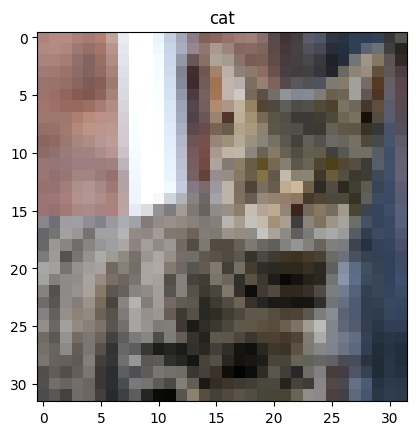

In [51]:
plt.imshow(img.permute(1,2,0))
plt.title(classes[pred_classes])
plt.show()

In [8]:
test_tensor = torch.randn((1,3,300,300))
model_2 = VGGBase()
model_3 = VGGAuxiliaryConvolutional()
model_3(model_2(test_tensor)[1])

torch.Size([1, 256, 1, 1])


tensor([[[[0.0000]],

         [[0.0000]],

         [[0.0277]],

         [[0.0000]],

         [[0.0000]],

         [[0.0409]],

         [[0.0000]],

         [[0.0192]],

         [[0.0000]],

         [[0.0000]],

         [[0.0234]],

         [[0.0057]],

         [[0.0189]],

         [[0.0000]],

         [[0.0000]],

         [[0.0249]],

         [[0.0286]],

         [[0.0000]],

         [[0.0000]],

         [[0.0035]],

         [[0.0000]],

         [[0.0164]],

         [[0.0112]],

         [[0.0000]],

         [[0.0000]],

         [[0.0022]],

         [[0.0000]],

         [[0.0334]],

         [[0.0000]],

         [[0.0000]],

         [[0.0000]],

         [[0.0000]],

         [[0.0000]],

         [[0.0255]],

         [[0.0005]],

         [[0.0180]],

         [[0.0000]],

         [[0.0000]],

         [[0.0243]],

         [[0.0151]],

         [[0.0176]],

         [[0.0000]],

         [[0.0000]],

         [[0.0032]],

         [[0.0176]],

         [